## MONITORIZATION

In [1]:
#!conda install pyspark

In [1]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier import *
from utils.df_transformations import *

# import necesary libraries
import os
import sys

#pysparl libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column
from utils.partitions import *

from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

In [2]:
# load data
table_name_loans = 'emol_loans_finan_amounts_dp'
modelDataFile = "data/" + table_name_loans + ".csv"

#loans
df_emol_loans = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)


#cards
table_name_cards = 'emol_cards_amounts_dp'
modelDataFile = "data/" + table_name_cards + ".csv"

df_emol_cards = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

In [3]:
df_emol_loans = date_concatenation(df_emol_loans, table_name_loans)
df_emol_cards = date_concatenation(df_emol_cards, table_name_cards)

In [4]:
df_input = (df_emol_cards.join(df_emol_loans, ['partition'], 'inner')
            .withColumn("Execution", to_timestamp(concat_ws(' ', date_format(sf.date_add(col('partition'), 1), 'yyyy-MM-dd'), lit('05:00')), 'yyyy-MM-dd HH:mm')))
df_input.show()

+-------------------+---------------------+---------------------------+-------------------+
|          partition|emol_cards_amounts_dp|emol_loans_finan_amounts_dp|          Execution|
+-------------------+---------------------+---------------------------+-------------------+
|2020-02-17 00:00:00|  2020-03-30 17:14:00|        2020-07-02 17:45:00|2020-02-18 05:00:00|
|2020-02-18 00:00:00|  2020-03-30 17:15:00|        2020-07-02 18:57:00|2020-02-19 05:00:00|
|2020-02-19 00:00:00|  2020-03-30 17:16:00|        2020-07-02 19:34:00|2020-02-20 05:00:00|
|2020-02-20 00:00:00|  2020-03-30 17:25:00|        2020-07-02 20:08:00|2020-02-21 05:00:00|
|2020-02-21 00:00:00|  2020-03-30 17:30:00|        2020-07-02 20:49:00|2020-02-22 05:00:00|
|2020-02-24 00:00:00|  2020-02-25 02:05:00|        2020-07-02 21:17:00|2020-02-25 05:00:00|
|2020-02-25 00:00:00|  2020-02-26 17:34:00|        2020-07-02 21:47:00|2020-02-26 05:00:00|
|2020-02-26 00:00:00|  2020-02-27 01:30:00|        2020-07-02 22:16:00|2020-02-2

In [5]:
def days_delays(df, table_name):
    df= (df
               .withColumn('DiffInSeconds',col(table_name).cast("long") - col('partition').cast("long"))
                .withColumn(table_name,col("DiffInSeconds")/(3600*24)).drop('DiffInSeconds')
                           )
    return df

In [6]:
#CALCULATE THE NUMBER OF DAYS OF DELAY
df_input = days_delays(df_input, table_name_loans)
df_input = days_delays(df_input, table_name_cards)
df_input = days_delays(df_input, 'Execution')
df_input.show()

+-------------------+---------------------+---------------------------+------------------+
|          partition|emol_cards_amounts_dp|emol_loans_finan_amounts_dp|         Execution|
+-------------------+---------------------+---------------------------+------------------+
|2020-02-17 00:00:00|    42.67638888888889|         136.69791666666666|1.2083333333333333|
|2020-02-18 00:00:00|   41.677083333333336|         135.74791666666667|1.2083333333333333|
|2020-02-19 00:00:00|    40.67777777777778|          134.7736111111111|1.2083333333333333|
|2020-02-20 00:00:00|    39.68402777777778|         133.79722222222222|1.2083333333333333|
|2020-02-21 00:00:00|              38.6875|         132.82569444444445|1.2083333333333333|
|2020-02-24 00:00:00|   1.0868055555555556|          129.8451388888889|1.2083333333333333|
|2020-02-25 00:00:00|   1.7319444444444445|          128.8659722222222|1.2083333333333333|
|2020-02-26 00:00:00|               1.0625|          127.8861111111111|1.2083333333333333|

In [7]:
# CALCULATE METRICS
df_input_part = df_input.withColumn('is_delay_loans', sf.when(col('emol_loans_finan_amounts_dp')> col('Execution'), 1).otherwise(0))
df_input_part = df_input_part.withColumn('is_delay_cards', sf.when(col('emol_cards_amounts_dp')> col('Execution'), 1).otherwise(0))
df_input_part =df_input_part.select('partition', 'is_delay_loans', 'is_delay_cards').withColumn('monthy_partition', create_partitions_from_df('partition', "yyyy-MM-dd"))
df_input_part = (df_input_part.groupBy("monthy_partition").agg(sf.sum('is_delay_loans'), sf.sum('is_delay_cards'))
.withColumnRenamed('sum(is_delay_loans)', 'n_delay_loans')
.withColumnRenamed('sum(is_delay_cards)', 'n_delay_cards'))

In [8]:
df_input_part.sort('monthy_partition', ascending = False).show()

+----------------+-------------+-------------+
|monthy_partition|n_delay_loans|n_delay_cards|
+----------------+-------------+-------------+
|      2021-04-30|            5|            6|
|      2021-03-31|            5|           13|
|      2021-02-28|            4|            2|
|      2021-01-31|            2|            3|
|      2020-12-31|            1|            1|
|      2020-11-30|            4|            4|
|      2020-10-31|            6|            5|
|      2020-09-30|            5|            3|
|      2020-08-31|            2|            0|
|      2020-07-31|            1|            5|
|      2020-06-30|           15|            6|
|      2020-05-31|           20|            3|
|      2020-04-30|           21|            2|
|      2020-03-31|           22|            9|
|      2020-02-29|           10|            6|
+----------------+-------------+-------------+



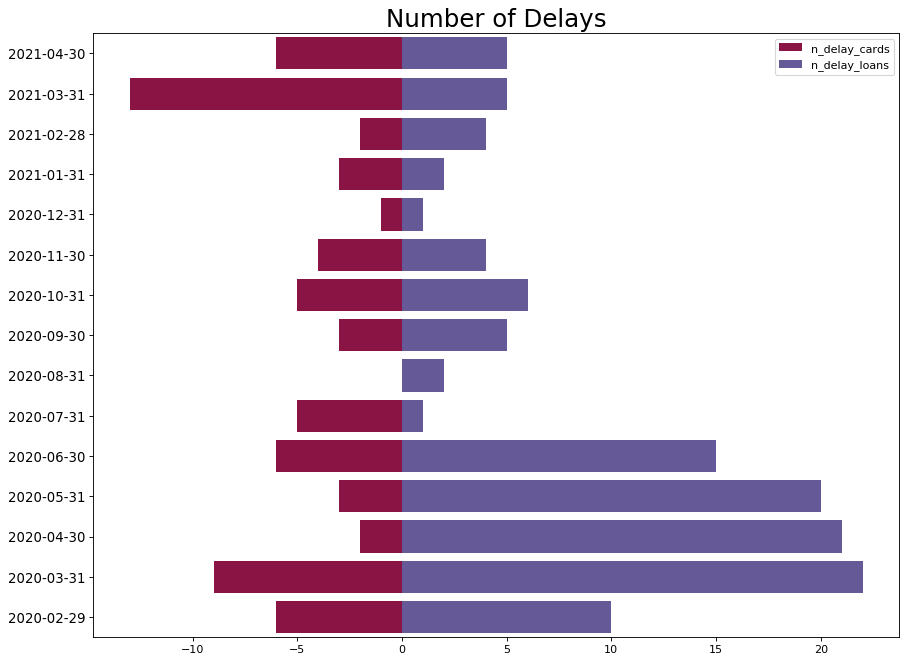

In [9]:
df_input_part = (df_input_part.withColumn('n_delay_cards', -1*col('n_delay_cards')))
df_input_part = to_explode(df_input_part,['monthy_partition'])

group_col = 'field'
x_values = 'movs'
cat = 'monthy_partition'
title = "Number of Delays"
x_title = ""
ylabel = ""
    
plot_piramid(df_input_part.toPandas().sort_values(by=[cat]), 
             group_col, x_values, cat, title, x_title, ylabel)

In [10]:
df_transf = to_explode(df_input.select('partition', table_name_loans, table_name_cards, 'Execution'),['partition'])
df_transf = (df_transf.withColumn("partition", to_date(from_unixtime(unix_timestamp('partition', 'yyMMdd'))))
             .withColumn('year', year('partition')).withColumn('month', month('partition'))
             .withColumn('partition', col('partition').cast('string')))
df_transf.show(20, False)

+----------+---------------------------+------------------+----+-----+
|partition |field                      |movs              |year|month|
+----------+---------------------------+------------------+----+-----+
|2020-02-17|emol_loans_finan_amounts_dp|136.69791666666666|2020|2    |
|2020-02-17|emol_cards_amounts_dp      |42.67638888888889 |2020|2    |
|2020-02-17|Execution                  |1.2083333333333333|2020|2    |
|2020-02-18|emol_loans_finan_amounts_dp|135.74791666666667|2020|2    |
|2020-02-18|emol_cards_amounts_dp      |41.677083333333336|2020|2    |
|2020-02-18|Execution                  |1.2083333333333333|2020|2    |
|2020-02-19|emol_loans_finan_amounts_dp|134.7736111111111 |2020|2    |
|2020-02-19|emol_cards_amounts_dp      |40.67777777777778 |2020|2    |
|2020-02-19|Execution                  |1.2083333333333333|2020|2    |
|2020-02-20|emol_loans_finan_amounts_dp|133.79722222222222|2020|2    |
|2020-02-20|emol_cards_amounts_dp      |39.68402777777778 |2020|2    |
|2020-

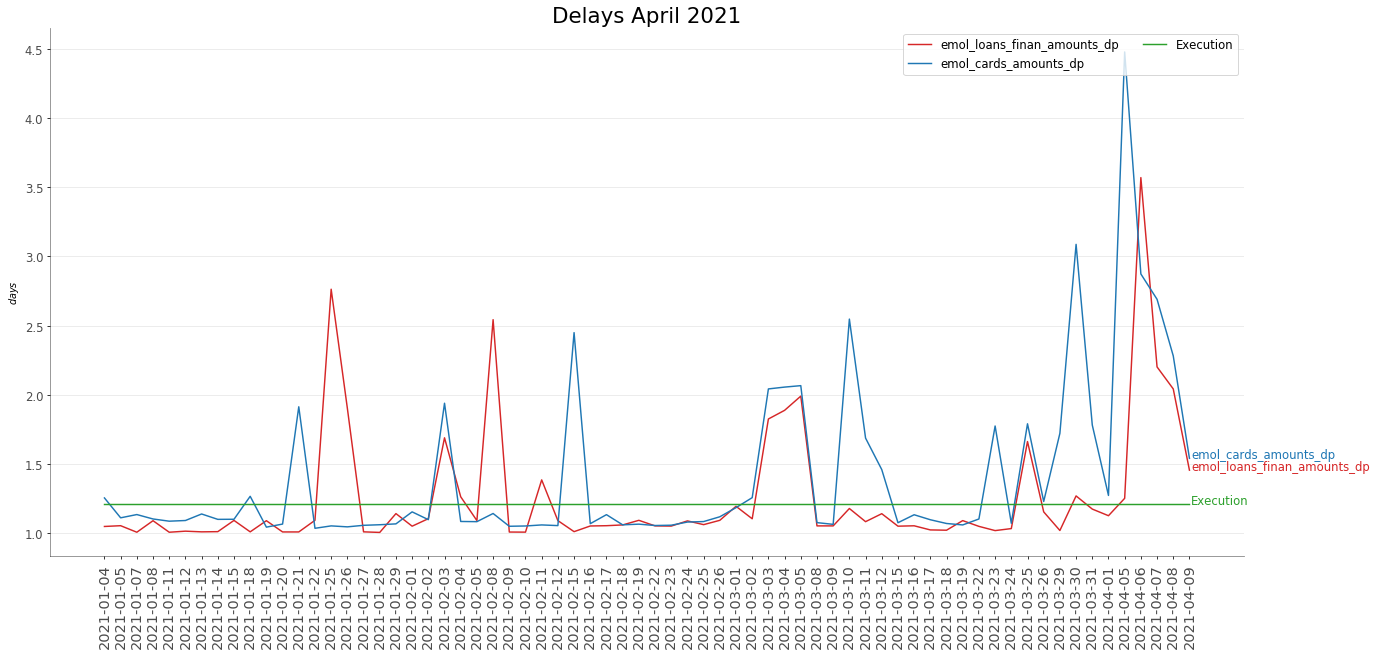

In [18]:
# April 2021
df_input_202104 = df_transf.filter(col('year') == '2021').filter(col('month').isin('4', '3', '2', '1'))
import pandas as pd
df = df_input_202104.toPandas()
# plot
title = "Delays April 2021"
ytitle = '$days$'
date_name = 'partition'
yaxis_field = 'movs'
type_col = 'field'
plot_different_type_series(df, date_name, yaxis_field, type_col, title, ytitle, dpi_value = 70, width = 22)

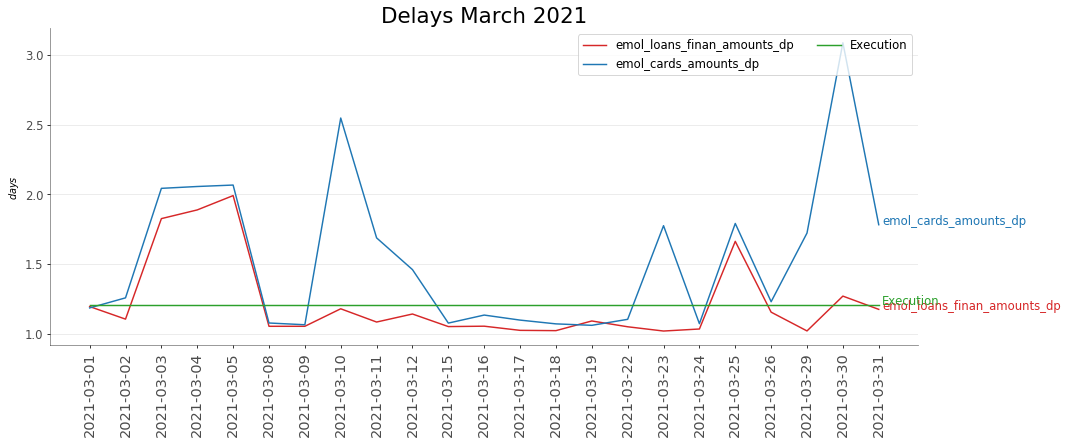

In [22]:
# March 2021
df_input_202103 = df_transf.filter(col('year') == '2021').filter(col('month') == '3')
import pandas as pd
df = df_input_202103.toPandas()
# plot
title = "Delays March 2021"
ytitle = '$days$'
date_name = 'partition'
yaxis_field = 'movs'
type_col = 'field'
plot_different_type_series(df, date_name, yaxis_field, type_col, title, ytitle, dpi_value = 70, height = 6)


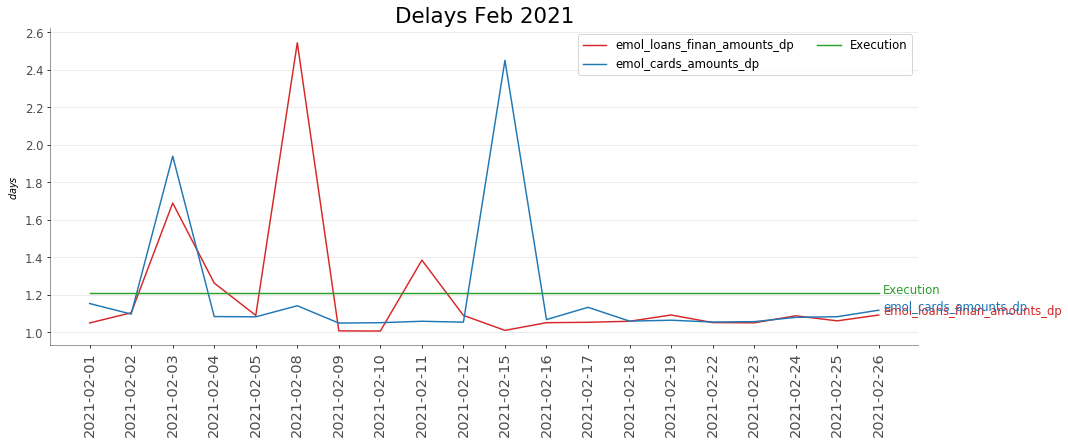

In [23]:
# Feb 2021
df_input_202102 = df_transf.filter(col('year') == '2021').filter(col('month') == '2')
import pandas as pd
df = df_input_202102.toPandas()
# plot
title = "Delays Feb 2021"
ytitle = '$days$'
date_name = 'partition'
yaxis_field = 'movs'
type_col = 'field'
plot_different_type_series(df, date_name, yaxis_field, type_col, title, ytitle, dpi_value = 70, height = 6)



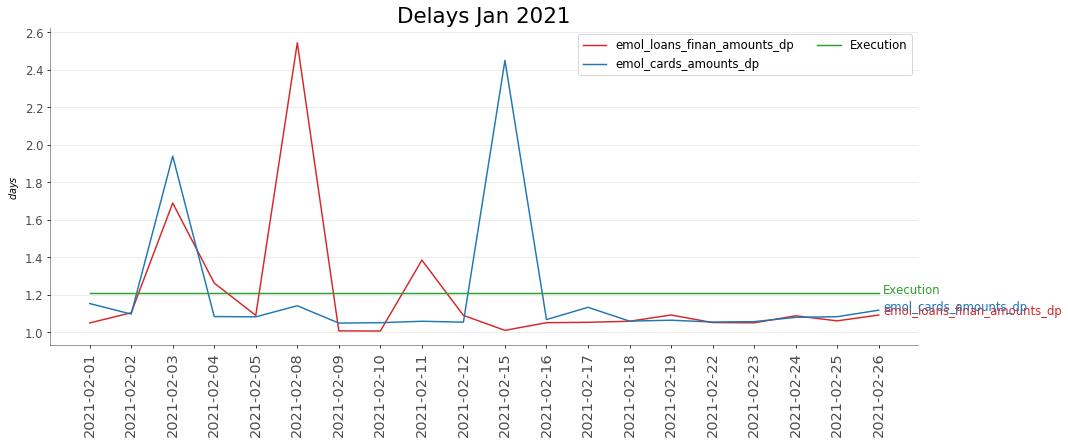

In [24]:
# Jan 2021
df_input_202102 = df_transf.filter(col('year') == '2021').filter(col('month') == '2')
import pandas as pd
df = df_input_202102.toPandas()
# plot
title = "Delays Jan 2021"
ytitle = '$days$'
date_name = 'partition'
yaxis_field = 'movs'
type_col = 'field'
plot_different_type_series(df, date_name, yaxis_field, type_col, title, ytitle, dpi_value = 70, height = 6)


In [14]:

import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/email_campaign_funnel.csv")



In [15]:
df.head()

,Stage,Gender,Users
0,Stage 01: Browsers,Male,-1.492762e+07
1,Stage 02: Unbounced Users,Male,-1.286266e+07
2,Stage 03: Email Signups,Male,-1.136190e+07
3,Stage 04: Email Confirmed,Male,-9.411708e+06
4,Stage 05: Campaign-Email Opens,Male,-8.074317e+06


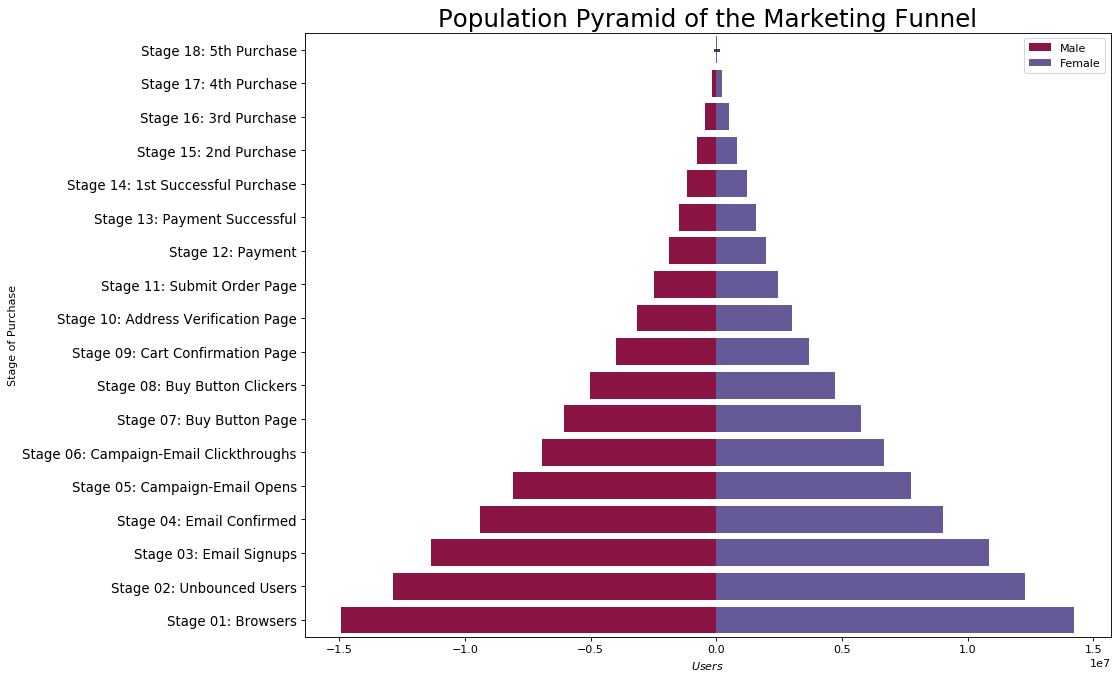

In [16]:
# Draw Plot

group_col = 'Gender'
x_values = 'Users'
cat = 'Stage'
title = "Population Pyramid of the Marketing Funnel"
x_title = "$Users$"
ylabel = "Stage of Purchase"
    
plot_piramid(df, group_col, x_values, cat, title, x_title, ylabel)